# Baran Akyol
## COMS W4721 Homework 3 


In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from collections import Counter
import time
# 1.82 6.913 

## Problem 1 (Gaussian process)

In [4]:
X_test = pd.read_csv('gaussian_process/X_test.csv',header=None).values
X_train = pd.read_csv('gaussian_process/X_train.csv',header=None).values
y_test = pd.read_csv('gaussian_process/y_test.csv',header=None).values
y_train = pd.read_csv('gaussian_process/y_train.csv',header=None).values

## a)

In [5]:

def gaussian_kernel(x1,x2,b):
    #Radial Basis Function using L2 Norm
    return np.exp(np.square(distance.cdist(x1,x2))/-float(b))



def mu_x(x0,X_train,y_train,b,sigma):
    #mean function for Gaussian Process
    
    N = X_train.shape[0]
    
    I = np.identity(N)
        
    K = gaussian_kernel(X_train,X_train,b)
    
    KD = gaussian_kernel(x0,X_train,b)
    
    
    return np.dot(np.dot(KD, np.linalg.inv(sigma * I  + K)), y_train)



def RMSE(ypred,ytruth):
    #RMSE
    return np.sqrt((np.sum((ypred - ytruth) ** 2))/float(ypred.shape[0]))


# b)

In [6]:
b_array = [5,7,9,11,13,15]
sigma_array = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

Table = pd.DataFrame(index = ['b = '+ str(b) for b in b_array],columns=['s = ' + str(sigma) for sigma in sigma_array])

counter1 = 0

for b in b_array:
    counter2 = 0
    for sigma in sigma_array:
        
        Table.iloc[counter1,counter2] = RMSE(mu_x(X_test,X_train,y_train,b,sigma),y_test)
        counter2 += 1
        
    counter1 += 1
    
Table

,s = 0.1,s = 0.2,s = 0.3,s = 0.4,s = 0.5,s = 0.6,s = 0.7,s = 0.8,s = 0.9,s = 1
b = 5,1.96628,1.93314,1.92342,1.9222,1.92477,1.92921,1.93463,1.94058,1.94682,1.95321
b = 7,1.92016,1.90488,1.90808,1.9159,1.9248,1.9337,1.94225,1.95038,1.95809,1.96544
b = 9,1.89765,1.90252,1.91765,1.93251,1.9457,1.95723,1.9674,1.97649,1.98474,1.99234
b = 11,1.89051,1.91498,1.93885,1.95794,1.97322,1.98576,1.99638,2.0056,2.01384,2.02134
b = 13,1.89585,1.93559,1.9646,1.9855,2.00131,2.01388,2.02431,2.03331,2.04132,2.04864
b = 15,1.9096,1.95955,1.9908,2.01192,2.02737,2.03947,2.04946,2.0581,2.06585,2.07298


# c)

In the first homework, RMSE for p = 1 started from ~2.6 and increased up to ~3.3. For p = 2 and 3 the lowest was around 2.2 and again it increased past 3. We see that RMSE for Gaussian Process performs slightly better with a range of ~1.89 and ~2.07 . It also has less variance among the parameters used. The best value 1.89051, which performs better than the model in the first homework, was when b was 13 and s was 0.1. That being said, Gauissian Process Regression is also more complex and less interpretable and as such would not scale as well as Ridge Regression with larger data sets. Gaussian Process might also overfit the training set and tuning the hyperparameters for the Gaussian Proces and achieving regularization will not be as easy and effective as it is for Ridge Regression

# d)

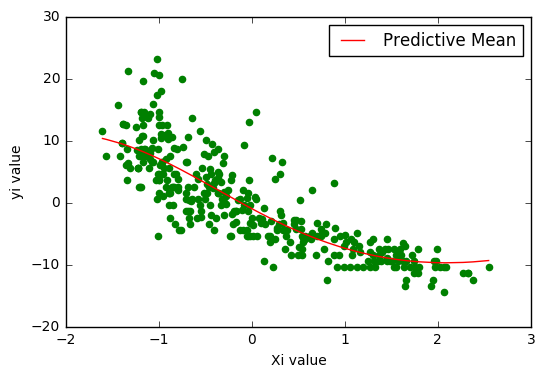

In [9]:
x4 = X_train[:,3].reshape(350,1)
foo = np.hstack((x4,y_train))
bar = foo[foo[:, 0].argsort()]
x4sorted = bar[:,0].reshape(350,1)
ysorted =  bar[:,1].reshape(350,1)

predictive_mean = mu_x(x4sorted,x4sorted,ysorted,5,2)

plt.scatter(x4,y_train,color = 'g')

plt.plot(x4sorted,predictive_mean,color = 'r',label = 'Predictive Mean')
plt.legend()
plt.xlabel('Xi value')
plt.ylabel('yi value')

plt.show()

## Problem 2 (Boosting coding)


In [110]:
X_test = pd.read_csv('boosting/X_test.csv',header=None).values
X_train = pd.read_csv('boosting/X_train.csv',header=None).values
y_test = pd.read_csv('boosting/y_test.csv',header=None).values
y_train = pd.read_csv('boosting/y_train.csv',header=None).values

X_train = np.insert(X_train,5,1,axis=1)
X_test = np.insert(X_test,5,1,axis=1)


In [111]:
def learn_classifier(BX,By):
    #input X and y for training
    return np.dot(np.dot(np.linalg.inv(np.dot(BX.T,BX)),BX.T),By)

In [112]:
def predict_classifier(X,param):
    #input X and w vector
    return np.sign(np.dot(X,param))

In [113]:
def sample_bootstrap(X,y,w):
    
    N = X.shape[0]
 
    B = np.random.choice(N, N, p=w.flatten())
     
    return X[B], y[B], B

In [114]:
def update_w(y_truth,w,X_train,param):
    
    y_pred = predict_classifier(X_train,param)


    
    epsilon = np.sum(w[np.where(y_pred != y_truth)[0]])
    
    if epsilon > 0.5:
        param = -param
        y_pred = predict_classifier(X_train,param)
        epsilon = np.sum(w[np.where(y_pred != y_truth)[0]])
    
   
    alpha = np.log((1-epsilon)/epsilon) /2.
    
    w_hat = np.exp(-alpha * y_truth * y_pred).flatten() * w
    
    return w_hat/float(np.sum(w_hat)), alpha, epsilon, y_pred,param


In [115]:
def measure_error(y_pred,y_truth):
    
    return len(np.where(y_truth != y_pred)[0])/float(y_pred.shape[0])
    

In [116]:
def AdaBoost(X_train,y_train,X_test,y_test,T):
    
    N = X_train.shape[0]
    
    w = np.full(N,1./N)
    
    # create arrays  for:
    # part a 
    fboost_test = [];fboost_train = [];training_error = [];test_error = []
    
    # part b
    at_t =[];upper_bound = []
    
    # part c
    B_total = {}
    
    # part d
    epsilon_array = [];alpha_array = []
    
    for t in range(T):
        
        # Sample Boostrap using weights
        Bx, By, B = sample_bootstrap(X_train,y_train,w)
        
        # Learn model parameters on the Bootstrap data
        param = learn_classifier(Bx,By)
        
        # Predict training set using learned parameters
        
        # Calculate alpha and update w
        w, alpha, epsilon, y_pred,param = update_w( y_train, w, X_train, param)
        
            
        # Predict test set using the parameters
        f_test = predict_classifier(X_test,param)
        
        
        # Record decisions for test and training at each t
        fboost_train.append(alpha * y_pred)
        fboost_test.append(alpha * f_test)

        # Record error for each t
        training_error.append(measure_error(np.sign(np.sum(fboost_train,axis=0)),y_train))
        test_error.append(measure_error(np.sign(np.sum(fboost_test,axis=0)),y_test))
        
        # append upper bound for each t
        at_t.append((0.5 - epsilon)**2)
        upper_bound.append(np.exp(-2 * np.sum(at_t)))
        
        B_total = dict(Counter(B_total) + Counter(B))
    
        epsilon_array.append(epsilon)
        alpha_array.append(alpha)
    
    return training_error, test_error, upper_bound, B_total, epsilon_array, alpha_array
        
        

In [128]:
training_error, testing_error, upper_bound, B_total,epsilon_array,alpha_array = AdaBoost(X_train,y_train,X_test,y_test,1500)

# a)

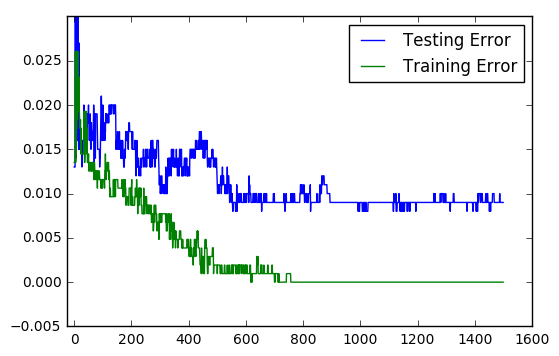

In [143]:
plt.plot(range(1500),testing_error,label = 'Testing Error')
plt.plot(range(1500),training_error,label = 'Training Error')

plt.xlim(-25,1600)
plt.ylim(-0.005,0.030)

plt.xlabel('X_i value')
plt.ylabel('y_i value')

plt.legend()
plt.show()

# b)

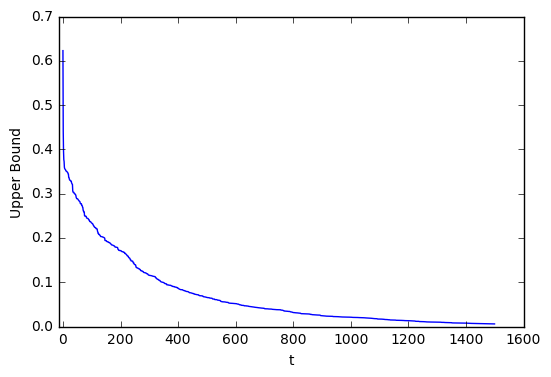

In [144]:
plt.plot(upper_bound,color='b')
plt.xlim(-15,1600)
plt.xlabel('t')
plt.ylabel('Upper Bound')
plt.show()

# c)

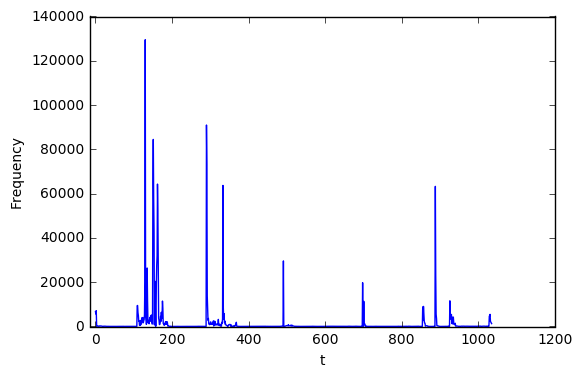

In [149]:
xi, freq = zip(*[i for i in B_total.iteritems()])
plt.plot(xi,freq)
plt.xlim(-15,1200)
plt.ylim(-10,140000)

plt.xlabel('t')
plt.ylabel('Frequency')

plt.show()

# d)

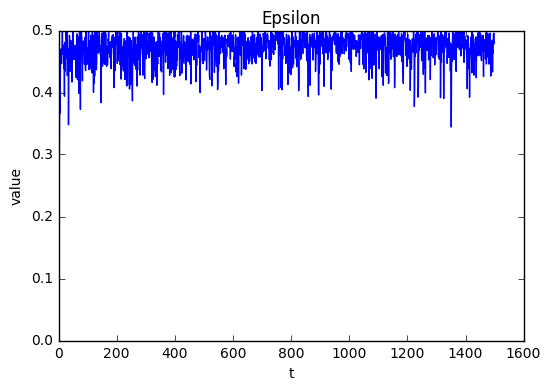

In [156]:
plt.plot(epsilon_array)
plt.title('Epsilon')
plt.xlabel('t')
plt.ylabel('value')

plt.show()

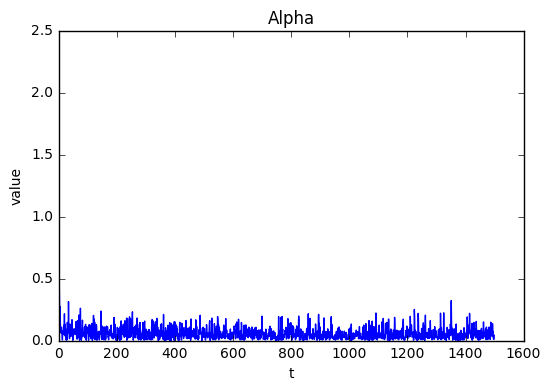

In [160]:
plt.plot(alpha_array)
plt.title('Alpha')
plt.xlabel('t')
plt.ylabel('value')

plt.show()